<a href="https://colab.research.google.com/github/GuptaNavdeep1983/CS767/blob/main/PingPong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [3]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')

('Roms.rar', <http.client.HTTPMessage at 0x7f3e3072ff50>)

In [6]:
!pip install unrar
!unrar x Roms.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK


In [8]:
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars

mkdir: cannot create directory ‘rars’: File exists
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/assault.bin
copying asterix.bin from ROMS/Asterix (AKA Taz) (07-27-1983) (Atari, Jerome Domurat, Steve Woita) (CX2696) (Prototy

In [17]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [20]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [9]:
env = gym.make('BreakoutDeterministic-v4')

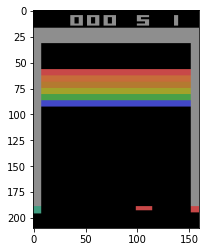

In [10]:
first_frame = env.reset()
plt.imshow(first_frame)

Reward Recieved = 0.0
Next state is a terminal state: False
info[ale.lives] tells us how many lives we have. Lives: 5


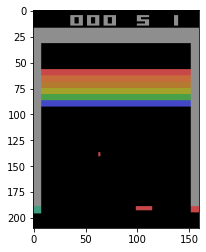

In [14]:
next_frame, next_frames_reward, done, info = env.step(1)

plt.imshow(next_frame)
print('Reward Recieved = ' + str(next_frames_reward))
print('Next state is a terminal state: ' + str(done))
print('info[ale.lives] tells us how many lives we have. Lives: ' + str(info['ale.lives']))

KeyboardInterrupt: ignored

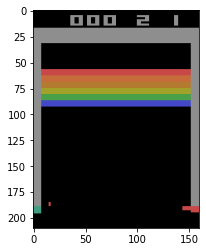

In [28]:
for i in range(10000):
    a = random.sample([0,1,2,3] , 1)[0]
    f_p,r,d,info = env.step(a)
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    if d == True:
        env.reset()

In [24]:
import cv2
import numpy as np


def resize_frame(frame):
    frame = frame[30:-12,5:-4]
    frame = np.average(frame,axis = 2)
    frame = cv2.resize(frame,(84,84),interpolation = cv2.INTER_NEAREST)
    frame = np.array(frame,dtype = np.uint8)
    return frame

In [25]:
from collections import deque

class Memory():
    def __init__(self,max_len):
        self.max_len = max_len
        self.frames = deque(maxlen = max_len)
        self.actions = deque(maxlen = max_len)
        self.rewards = deque(maxlen = max_len)
        self.done_flags = deque(maxlen = max_len)

    def add_experience(self,next_frame, next_frames_reward, next_action, next_frame_terminal):
        self.frames.append(next_frame)
        self.actions.append(next_action)
        self.rewards.append(next_frames_reward)
        self.done_flags.append(next_frame_terminal)

In [37]:
import gym
import numpy as np


def initialize_new_game(name, env, agent):
    """We don't want an agents past game influencing its new game, so we add in some dummy data to initialize"""
    
    env.reset()
    starting_frame = resize_frame(env.step(0)[0])

    dummy_action = 0
    dummy_reward = 0
    dummy_done = False
    for i in range(3):
        agent.memory.add_experience(starting_frame, dummy_reward, dummy_action, dummy_done)

def make_env(name, agent):
    env = gym.make(name)
    return env

def take_step(name, env, agent, score, debug):
    
    #1 and 2: Update timesteps and save weights
    agent.total_timesteps += 1
    if agent.total_timesteps % 50000 == 0:
      agent.model.save_weights('recent_weights.hdf5')
      print('\nWeights saved!')

    #3: Take action
    next_frame, next_frames_reward, next_frame_terminal, info = env.step(agent.memory.actions[-1])
    
    #4: Get next state
    next_frame = resize_frame(next_frame)
    new_state = [agent.memory.frames[-3], agent.memory.frames[-2], agent.memory.frames[-1], next_frame]
    new_state = np.moveaxis(new_state,0,2)/255 #We have to do this to get it into keras's goofy format of [batch_size,rows,columns,channels]
    new_state = np.expand_dims(new_state,0) #^^^
    
    #5: Get next action, using next state
    next_action = agent.get_action(new_state)

    #6: If game is over, return the score
    if next_frame_terminal:
        agent.memory.add_experience(next_frame, next_frames_reward, next_action, next_frame_terminal)
        return (score + next_frames_reward),True

    #7: Now we add the next experience to memory
    agent.memory.add_experience(next_frame, next_frames_reward, next_action, next_frame_terminal)

    #8: If we are trying to debug this then render
    if debug:
        env.render()

    #9: If the threshold memory is satisfied, make the agent learn from memory
    if len(agent.memory.frames) > agent.starting_mem_len:
        agent.learn(debug)

    return (score + next_frames_reward),False

def play_episode(name, env, agent, debug = False):
    initialize_new_game(name, env, agent)
    done = False
    score = 0
    while True:
        score,done = take_step(name,env,agent,score, debug)
        if done:
            break
    return score

In [33]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf

import numpy as np
import random


class Agent():
    def __init__(self,possible_actions,starting_mem_len,max_mem_len,starting_epsilon,learn_rate, starting_lives = 5, debug = False):
        self.memory = Memory(max_mem_len)
        self.possible_actions = possible_actions
        self.epsilon = starting_epsilon
        self.epsilon_decay = .9/100000
        self.epsilon_min = .05
        self.gamma = .95
        self.learn_rate = learn_rate
        self.model = self._build_model()
        self.model_target = clone_model(self.model)
        self.total_timesteps = 0
        self.lives = starting_lives #this parameter does not apply to pong
        self.starting_mem_len = starting_mem_len
        self.learns = 0


    def _build_model(self):
        model = Sequential()
        model.add(Input((84,84,4)))
        model.add(Conv2D(filters = 32,kernel_size = (8,8),strides = 4,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Conv2D(filters = 64,kernel_size = (4,4),strides = 2,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Conv2D(filters = 64,kernel_size = (3,3),strides = 1,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Flatten())
        model.add(Dense(512,activation = 'relu', kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Dense(len(self.possible_actions), activation = 'linear'))
        optimizer = Adam(self.learn_rate)
        model.compile(optimizer, loss=tf.keras.losses.Huber())
        model.summary()
        print('\nAgent Initialized\n')
        return model

    def get_action(self,state):
        """Explore"""
        if np.random.rand() < self.epsilon:
            return random.sample(self.possible_actions,1)[0]

        """Do Best Acton"""
        a_index = np.argmax(self.model.predict(state))
        return self.possible_actions[a_index]

    def _index_valid(self,index):
        if self.memory.done_flags[index-3] or self.memory.done_flags[index-2] or self.memory.done_flags[index-1] or self.memory.done_flags[index]:
            return False
        else:
            return True

    def learn(self,debug = False):
        """we want the output[a] to be R_(t+1) + Qmax_(t+1)."""
        """So target for taking action 1 should be [output[0], R_(t+1) + Qmax_(t+1), output[2]]"""

        """First we need 32 random valid indicies"""
        states = []
        next_states = []
        actions_taken = []
        next_rewards = []
        next_done_flags = []

        while len(states) < 32:
            index = np.random.randint(4,len(self.memory.frames) - 1)
            if self._index_valid(index):
                state = [self.memory.frames[index-3], self.memory.frames[index-2], self.memory.frames[index-1], self.memory.frames[index]]
                state = np.moveaxis(state,0,2)/255
                next_state = [self.memory.frames[index-2], self.memory.frames[index-1], self.memory.frames[index], self.memory.frames[index+1]]
                next_state = np.moveaxis(next_state,0,2)/255

                states.append(state)
                next_states.append(next_state)
                actions_taken.append(self.memory.actions[index])
                next_rewards.append(self.memory.rewards[index+1])
                next_done_flags.append(self.memory.done_flags[index+1])

        """Now we get the ouputs from our model, and the target model. We need this for our target in the error function"""
        labels = self.model.predict(np.array(states))
        next_state_values = self.model_target.predict(np.array(next_states))
        
        """Now we define our labels, or what the output should have been
           We want the output[action_taken] to be R_(t+1) + Qmax_(t+1) """
        for i in range(32):
            action = self.possible_actions.index(actions_taken[i])
            labels[i][action] = next_rewards[i] + (not next_done_flags[i]) * self.gamma * max(next_state_values[i])

        """Train our model using the states and outputs generated"""
        self.model.fit(np.array(states),labels,batch_size = 32, epochs = 1, verbose = 0)

        """Decrease epsilon and update how many times our agent has learned"""
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay
        self.learns += 1
        
        """Every 10000 learned, copy our model weights to our target model"""
        if self.learns % 10000 == 0:
            self.model_target.set_weights(self.model.get_weights())
            print('\nTarget model updated')

In [ ]:
import matplotlib.pyplot as plt
import time
from collections import deque
import numpy as np

name = 'PongDeterministic-v4'

agent = Agent(possible_actions=[0,2,3],starting_mem_len=50000,max_mem_len=750000,starting_epsilon = 1, learn_rate = .00025)
env = make_env(name,agent)

last_100_avg = [-21]
scores = deque(maxlen = 100)
max_score = -21

""" If testing:
agent.model.load_weights('recent_weights.hdf5')
agent.model_target.load_weights('recent_weights.hdf5')
agent.epsilon = 0.0
"""

env.reset()

for i in range(1000000):
    timesteps = agent.total_timesteps
    timee = time.time()
    score = play_episode(name, env, agent, debug = False) #set debug to true for rendering
    scores.append(score)
    if score > max_score:
        max_score = score

    print('\nEpisode: ' + str(i))
    print('Steps: ' + str(agent.total_timesteps - timesteps))
    print('Duration: ' + str(time.time() - timee))
    print('Score: ' + str(score))
    print('Max Score: ' + str(max_score))
    print('Epsilon: ' + str(agent.epsilon))

    if i%100==0 and i!=0:
        last_100_avg.append(sum(scores)/len(scores))
        plt.plot(np.arange(0,i+1,100),last_100_avg)
        plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1606144   
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 1539      
Total params: 1,685,667
Trainable params: 1,685,667
Non-trainable params: 0
____________________________________________